<center><h1>GUMMADI_VIDYA SRI_PROJECT</h1></center>
<br>
<!-- <center><font size="4">Vertebral Column Data</font></center> -->

### Name: Vidya Sri Gummadi
### Github Username: Vidyasri22
### USC ID: 9563428770

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Text Classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tensorflow as tf
import keras
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

## (b) Data Exploration and Preprocessing

### (i)You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiment

Due to the utilization of the sigmoid activation function, which yields outputs within the range of 0 to 1, and the binary cross-entropy loss function, typically employed for binary classification tasks with labels 0 and 1, as highlighted in MLPs, CNNs, and LSTMs, I've made a slight adjustment to the labeling scheme. Specifically, I've assigned the label y=1 to denote positive sentiments and y=0 to represent negative sentiments to yeild better accuracies

In [3]:
def get_data(folder_path,label):

    data_files = os.listdir(folder_path)
    data_list =[]

    for file in data_files:
        if re.match(r'.*\.txt$', file):
            file_path = os.path.join(folder_path,file)
            with open(file_path, 'r') as f:
                content = f.read().replace('\n',',')
                if label == 'neg':
                    data_list.append({'content': content, 'label': 0})
                elif label == 'pos':
                    data_list.append({'content': content, 'label': 1})

    df = pd.DataFrame(data_list)
    return df

In [4]:
# neg_folder = '/content/drive/MyDrive/DSCI552/data/neg'
neg_folder = '../data/neg'
neg_data = get_data(neg_folder,'neg')
display(neg_data.head())

,content,label
0,first and foremost i think this movie comes to...,0
1,for timing reasons having to do with baby sitt...,0
2,my inner flag was at half-mast last year when ...,0
3,even the best comic actor is at the mercy of h...,0
4,five girls spend a day in a closed building do...,0


In [5]:
# pos_folder = '/content/drive/MyDrive/DSCI552/data/pos'
neg_folder = '../data/pos'
pos_data = get_data(pos_folder,'pos')
display(pos_data.head())

,content,label
0,there's an old saying that states something ab...,1
1,kolya is one of the richest films i've seen in...,1
2,carla gugino graduates from high school and in...,1
3,director jan de bont certainly knows how to ma...,1
4,getting it right is a far far cry from the tee...,1


### (ii) The data are pretty clean. Remove the punctuation and numbers from the data.

In [6]:
def remove_punctuations_and_numbers(text):
    pattern = r'[^a-zA-Z\s]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

neg_data['content'] = neg_data['content'].apply(lambda text: remove_punctuations_and_numbers(text))
display(neg_data.head())
pos_data['content'] = pos_data['content'].apply(lambda text: remove_punctuations_and_numbers(text))
display(pos_data.head())

,content,label
0,first and foremost i think this movie comes to...,0
1,for timing reasons having to do with baby sitt...,0
2,my inner flag was at halfmast last year when n...,0
3,even the best comic actor is at the mercy of h...,0
4,five girls spend a day in a closed building do...,0


,content,label
0,theres an old saying that states something abo...,1
1,kolya is one of the richest films ive seen in ...,1
2,carla gugino graduates from high school and in...,1
3,director jan de bont certainly knows how to ma...,1
4,getting it right is a far far cry from the tee...,1


### (iii) The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [7]:
train_neg_data = neg_data.iloc[0:700,:]
train_pos_data = pos_data.iloc[0:700,:]
test_neg_data = neg_data.iloc[700:,:]
test_pos_data = pos_data.iloc[700:,:]

train_data = pd.concat([train_neg_data,train_pos_data],ignore_index=True)
train_data = shuffle(train_data).reset_index(drop=True)
test_data = pd.concat([test_neg_data,test_pos_data],ignore_index=True)
test_data = shuffle(test_data).reset_index(drop=True)

In [8]:
print("Train dataset shape:",train_data.shape)
print("Test dataset shape:",test_data.shape)

Train dataset shape: (1400, 2)
Test dataset shape: (600, 2)


### (iv) Count the number of unique words in the whole dataset (train + test) and print it out.

In [9]:
all_text = ' '.join(train_data['content']) + ' '.join(test_data['content'])
words = all_text.split()
print(f"No.of Unique Words:{len(set(words))}")

No.of Unique Words:46787


### (v) Calculate the average review length and the standard deviation of review lengths. Report the results.

In [10]:
train_data['review_length'] = train_data['content'].apply(lambda x: len(x.split()))
test_data['review_length'] = test_data['content'].apply(lambda x: len(x.split()))

avg_review_length = (train_data['review_length'].sum() + test_data['review_length'].sum()) / 2000
print("Average Length of all review lengths:", avg_review_length)

# combined_lengths = train_data['review_length'].tolist() + test_data['review_length'].tolist()
std_dev = np.std(train_data['review_length'].tolist() + test_data['review_length'].tolist())
print("Standard deviation of all review lengths:", std_dev)

Average Length of all review lengths: 644.3465
Standard deviation of all review lengths: 284.97711212964106


### (vi) Plot the histogram of review lengths.

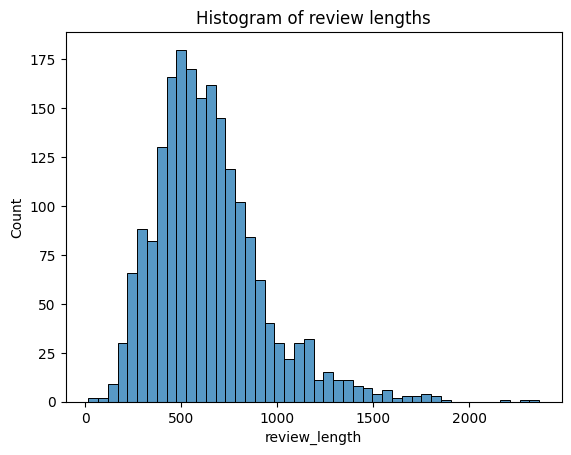

In [11]:
df_review_length = pd.concat([train_data['review_length'],test_data['review_length']],ignore_index=True)
sns.histplot(data=df_review_length)
plt.title("Histogram of review lengths")
plt.show()

From the histogram, we can observe that most of the reviews are in the range from 400-800. So this indicates that our data might have mostly contains the words which convey information succinctly.

### (vii) Tokenization

In general, having the corpus of only train data makes sense to get the tokenized vector and overall, fitting the tokenization process solely on the training data helps maintain the integrity of the machine learning workflow, prevents information leakage, and ensures fair and reliable evaluation of the model's performance on unseen data.

In [12]:
def tokenizer(x):
    docs = train_data['content'].tolist()
    t = Tokenizer()
    t.fit_on_texts(docs)
    encoded_docs = t.texts_to_sequences(x)
    return encoded_docs

In [13]:
train_data['tokenized'] = tokenizer(train_data['content'])
display(train_data.head())

,content,label,review_length,tokenized
0,first rule of fight club is dont talk about...,0,619,"[80, 1965, 4, 431, 1309, 6, 119, 570, 39, 431,..."
1,according to the publicity material with this...,0,711,"[2370, 5, 1, 4994, 619, 11, 14, 27, 1, 917, 51..."
2,an american werewolf in london is john landis ...,0,592,"[24, 275, 3207, 7, 2484, 6, 198, 10531, 5887, ..."
3,the year is and the military is conducting nu...,1,752,"[1, 228, 6, 3, 1, 1188, 6, 11947, 1555, 22807,..."
4,the camera zooms in incredibly close it focus...,0,597,"[1, 415, 7232, 7, 989, 538, 9, 2326, 19, 1, 45..."


In [14]:
test_data['tokenized'] = tokenizer(test_data['content'])
display(test_data.head())

,content,label,review_length,tokenized
0,while i am not fond of any writers use of chea...,0,452,"[90, 18, 737, 25, 5439, 4, 86, 1129, 342, 4, 1..."
1,three things i learned from being john malkov...,1,833,"[229, 168, 18, 1759, 29, 111, 198, 6157, 43, 3..."
2,in october of audiences were dazzled by the ...,1,813,"[7, 2837, 4, 787, 100, 34074, 21, 1, 322, 612,..."
3,note some may consider portions of the follow...,0,898,"[606, 49, 176, 1197, 4392, 4, 1, 780, 4211, 5,..."
4,the relaxed dude rides a roller coaster the bi...,1,981,"[1, 15750, 1656, 6223, 2, 7990, 8734, 1, 149, ..."


### (viii) Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [15]:
all_review_lengths = list(set(train_data['review_length'].values.tolist()))
all_review_lengths = sorted(all_review_lengths)
ind_70 = int(0.7 * len(all_review_lengths))
threshold_len = all_review_lengths[ind_70]
print("Threshold Length(L):",threshold_len)

Threshold Length(L): 822


### (ix) Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [16]:
def truncate(text_vector):
    if len(text_vector)>threshold_len:
        text_vector = text_vector[0:threshold_len]
    return text_vector

test_data['tokenized'] = test_data['tokenized'].apply(lambda x: truncate(x) if len(x) > threshold_len else x)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: truncate(x) if len(x) > threshold_len else x)

In [17]:
def pad_seq(num_array):
    padded_review = pad_sequences(num_array, maxlen=threshold_len, padding='post', truncating='post')
    return padded_review

padded_result_test = pad_seq(test_data['tokenized'].tolist())
test_data['tokenized'] = [np.array(seq) for seq in padded_result_test]

padded_result_train = pad_seq(train_data['tokenized'].tolist())
train_data['tokenized'] = [np.array(seq) for seq in padded_result_train]

In [18]:
train_data['tokenized_review_length'] = train_data['tokenized'].apply(lambda x: len(x))
test_data['tokenized_review_length'] = test_data['tokenized'].apply(lambda x: len(x))

display(train_data.head())
display(test_data.head())

,content,label,review_length,tokenized,tokenized_review_length
0,first rule of fight club is dont talk about...,0,619,"[80, 1965, 4, 431, 1309, 6, 119, 570, 39, 431,...",822
1,according to the publicity material with this...,0,711,"[2370, 5, 1, 4994, 619, 11, 14, 27, 1, 917, 51...",822
2,an american werewolf in london is john landis ...,0,592,"[24, 275, 3207, 7, 2484, 6, 198, 10531, 5887, ...",822
3,the year is and the military is conducting nu...,1,752,"[1, 228, 6, 3, 1, 1188, 6, 11947, 1555, 22807,...",822
4,the camera zooms in incredibly close it focus...,0,597,"[1, 415, 7232, 7, 989, 538, 9, 2326, 19, 1, 45...",822


,content,label,review_length,tokenized,tokenized_review_length
0,while i am not fond of any writers use of chea...,0,452,"[90, 18, 737, 25, 5439, 4, 86, 1129, 342, 4, 1...",822
1,three things i learned from being john malkov...,1,833,"[229, 168, 18, 1759, 29, 111, 198, 6157, 43, 3...",822
2,in october of audiences were dazzled by the ...,1,813,"[7, 2837, 4, 787, 100, 34074, 21, 1, 322, 612,...",822
3,note some may consider portions of the follow...,0,898,"[606, 49, 176, 1197, 4392, 4, 1, 780, 4211, 5,...",822
4,the relaxed dude rides a roller coaster the bi...,1,981,"[1, 15750, 1656, 6223, 2, 7990, 8734, 1, 149, ...",822


## (c) Word Embeddings

I tried adding the embedding layer separately, but I noticed that combining it with the model works better. This might be because it lets the model learn embedding representations alongside other parts during training. So, the model can adjust the embeddings to fit the task it's doing better.

In [19]:
# def word_embedding(col_values,MLP):
#     batch_size = col_values.shape[0]
#     input_array = np.stack(col_values.apply(np.array))
#     input_array[input_array > 4999] = 0
#     model = keras.Sequential()
#     model.add(keras.layers.Embedding(5000, 32, input_length=threshold_len))
#     model.compile('rmsprop', 'mse')
#     output_array = model.predict(input_array)
#     if MLP == 1:
#         final_output = output_array.reshape(output_array.shape[0], -1)
#         print(final_output.shape)
#         return final_output
#     else:
#         print(output_array.shape)
#         return output_array

In [20]:
# X_train = word_embedding(train_data['tokenized'],MLP=1).tolist()
# y_train  = np.array(train_data['label'].values)

In [21]:
# X_test = word_embedding(test_data['tokenized'],MLP=1).tolist()
# y_test  = np.array(test_data['label'].values)

In [22]:
X_train = np.stack(train_data['tokenized'].apply(np.array))
X_train[X_train > 4999] = 0
X_train = np.array(X_train)
y_train  = np.array(train_data['label'].values)

X_test = np.stack(test_data['tokenized'].apply(np.array))
X_test[X_test > 4999] = 0
X_test = np.array(X_test)
y_test  = np.array(test_data['label'].values)

## (d) Multi-Layer Perceptron

In [23]:
def create_mlp(input_shape, vocab_size):
    model = Sequential([
        
        # Embedding Layer
        Embedding(input_dim=vocab_size, output_dim=32, input_length=threshold_len),
        # Flattening the matrix obtained from Embedding layer for the dense layer
        Flatten(),
        
        # Hiiden Layer1
        Dense(50, activation='relu',input_shape=input_shape),
        Dropout(0.2),
        
        # Hidden Layer2
        Dense(50, activation='relu'),
        Dropout(0.5),
        
        # Hidden Layer3
        Dense(50, activation='relu'),
        Dropout(0.5),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    return model


model_mlp = create_mlp(input_shape=(threshold_len*32,),vocab_size=5000)
print("Output shape of the embedding layer:", model_mlp.layers[1].output_shape)
model_mlp.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

model_mlp.fit(X_train, y_train, epochs=2, batch_size=10)

train_loss_mlp, train_accuracy_mlp = model_mlp.evaluate(X_train, y_train, verbose=0)
print()
print(f"MLP Train Loss:{train_loss_mlp:.4f}")
print(f"MLP Train Accuracy:{train_accuracy_mlp*100:.4f}")

print()
test_loss_mlp, test_accuracy_mlp = model_mlp.evaluate(X_test, y_test, verbose=0)
print(f"MLP Test Loss:{test_loss_mlp:.4f}")
print(f"MLP Test Accuracy:{test_accuracy_mlp*100:.4f}")


Output shape of the embedding layer: (None, 26304)
Epoch 1/2
140/140 [==============================] - 22s 137ms/step - loss: 0.6990 - accuracy: 0.5136
Epoch 2/2
140/140 [==============================] - 14s 99ms/step - loss: 0.6466 - accuracy: 0.6200

MLP Train Loss:0.3838
MLP Train Accuracy:89.8571

MLP Test Loss:0.6256
MLP Test Accuracy:65.0000


## (e) 1D Convolutional Nueral Network

Here, in Conv1D layer of a CNN for text classification, I have incorporated the L2 Regularizer which helps promote better generalization performance, prevent overfitting, control model complexity, and improve robustness to noisy data.

In [25]:
def create_cnn(input_shape, vocab_size):
    model = Sequential([
        
        # Embedding Layer
        Embedding(input_dim=vocab_size, output_dim=32, input_length=threshold_len),
        
        '''Here, we are not flattening the output of Embedding Layer because the conv1D layer aceepts the input of 3D tensor which
        has shape of (batch_size,timesteps(certain review length),no.of features)'''
        
        # Conv1D Layer
        Conv1D(filters=32, kernel_size=3, input_shape=(input_shape),kernel_regularizer=l2(0.001)),
        
        # Max Pooling Layer
        MaxPooling1D(pool_size=2, strides=2),
       
        # Flatten the output of Max pooling which is a 3D tensor to give input to dense layer
        Flatten(),
        
        # Hidden Layer1
        Dense(50, activation='relu',input_shape=input_shape),
        Dropout(0.2),
        
        # Hidden Layer2
        Dense(50, activation='relu'),
        Dropout(0.5),
        
        # Hidden Layer3
        Dense(50, activation='relu'),
        Dropout(0.5),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    return model

model_cnn = create_cnn(input_shape=(threshold_len,32,),vocab_size=5000)

print("Output shape of the embedding layer:", model_cnn.layers[0].output_shape)

model_cnn.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=2, batch_size=10)

train_loss_cnn, train_accuracy_cnn = model_cnn.evaluate(X_train, y_train, verbose=0)
print()
print(f"CNN Train Loss:{train_loss_cnn:.4f}")
print(f"CNN Train Accuracy:{train_accuracy_cnn*100:.4f}")

print()
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Loss:{test_loss_cnn:.4f}")
print(f"CNN Test Accuracy:{test_accuracy_cnn*100:.4f}")

Output shape of the embedding layer: (None, 822, 32)
Epoch 1/2
140/140 [==============================] - 18s 112ms/step - loss: 0.7243 - accuracy: 0.4829
Epoch 2/2
140/140 [==============================] - 12s 85ms/step - loss: 0.7104 - accuracy: 0.5429

CNN Train Loss:0.6735
CNN Train Accuracy:65.9286

CNN Test Loss:0.7040
CNN Test Accuracy:56.8333


## (f) Long Short-Term Memory Recurrent Neural Network

Here, I just used the recurrent dropout for LSTM which also does the same as regularizer and dropout to see if we can improve the accuracies

In [27]:
def create_lstm(input_shape, vocab_size):
    model = Sequential([
        
        # Embedding Layer
        Embedding(input_dim=vocab_size, output_dim=32, input_length=threshold_len),
        
        '''Here, we are not flattening the output of Embedding Layer because the LSTM layer aceepts the input of 3D tensor which 
        has shape of (batch_size,timesteps(certain review length),no.of features)'''
        
        # LSTM layer
        LSTM(256, input_shape=(threshold_len,32,), dropout=0.2, recurrent_dropout=0.2),
        
        # Dense Layer of 256 Relu's
        Dense(256, activation='relu'),
        Dropout(0.2),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    return model


model_lstm = create_lstm(input_shape=(threshold_len,32,),vocab_size=5000)
print("Output shape of the embedding layer:", model_lstm.layers[0].output_shape)

model_lstm.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=15, batch_size=10)

train_loss_lstm, train_accuracy_lstm = model_lstm.evaluate(X_train, y_train, verbose=0)
print()
print(f"LSTM Train Loss:{train_loss_lstm:.4f}")
print(f"LSTM Train Accuracy:{train_accuracy_lstm*100:.4f}")

print()
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss:{test_loss_lstm:.4f}")
print(f"LSTM Test Accuracy:{test_accuracy_lstm*100:.4f}")

Output shape of the embedding layer: (None, 822, 32)
Epoch 1/15
140/140 [==============================] - 231s 2s/step - loss: 0.6924 - accuracy: 0.5143
Epoch 2/15
140/140 [==============================] - 228s 2s/step - loss: 0.6767 - accuracy: 0.5529
Epoch 3/15
140/140 [==============================] - 218s 2s/step - loss: 0.6331 - accuracy: 0.5957
Epoch 4/15
140/140 [==============================] - 217s 2s/step - loss: 0.6039 - accuracy: 0.6157
Epoch 5/15
140/140 [==============================] - 216s 2s/step - loss: 0.5739 - accuracy: 0.6214
Epoch 6/15
140/140 [==============================] - 214s 2s/step - loss: 0.5517 - accuracy: 0.6307
Epoch 7/15
140/140 [==============================] - 217s 2s/step - loss: 0.5594 - accuracy: 0.6257
Epoch 8/15
140/140 [==============================] - 218s 2s/step - loss: 0.5503 - accuracy: 0.6271
Epoch 9/15
140/140 [==============================] - 216s 2s/step - loss: 0.5593 - accuracy: 0.6300
Epoch 10/15
140/140 [=================

#### References

1. https://keras.io/
2. https://stats.stackexchange.com/questions/314510/keras-text-classification-overfitting-and-how-to-improve-my-model
3. https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/
4. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
5. https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
6. ChatGPT and stackoverflow to solve some errors